# What Noise Should I Choose?

## Introduction

In the examples up to now, we've been using `.noise()` to make our queries differentially private. However, there are different types of noise available including Laplacian noise and Gaussian noise. In this notebook, we will describe how the two noise distributions differ and how can one choose which is more appropriate for your particular analysis. 

The default `.noise()` by OpenDP chooses one of these distributions for you based on the limited information you've provided. However, with a better understanding of both distributions, you'll be able to specify the type of noise and its parameters for higher utility!

## Laplace vs. Gaussian

The Laplace and Gaussian distributions are the two primary mechanisms to add noise to ensure differential privacy and preserve relationships for statistical analysis. The two distributions may appear similar at a first glance, but there are key differences in their use in differential privacy techniques. 

**1. Definition of Privacy:**
 Differential privacy mechanisms using the Laplace distribution satisfy the pure ε-dp, whereas differentially private outputs using the Gaussian mechanism satisfy a more relaxed definition of differential privacy, ε-δ dp. Therefore, Laplace provides stronger privacy guarantees. 

**2. Accuracy:**
Differentially private outputs using the Gaussian mechanism are often further from the true answer compared to outputs using the Laplace mechanism.

This is supported by the following plot which graphs the emperical probability density function of the Laplace and Gaussian mechanisms with ε = 1 and δ = 10^-5. 

![Histogram of Laplace and Gaussian](https://programming-dp.com/_images/3022199fd49e470e2f86adb6c633df9f586459106067366915cd578cd7e05a5d.png)


3. Type of Output: 
Gaussian mechanisms perform better when the output is a vector of real numbers rather than a single real number. This is because the Laplace mechanism requires use of the L1 norm (sum of absolute values) and results in a sensitivity of k (length of output vector), whereas the Gaussian mechanism allows the use of the L1 norm or the L2 norm (Euclidean distance). With the Gaussian mechanism and L2 norm, the sensitivty can be $\sqrt{k}$ In such cases, the L2 sensitivity is significantly lower than the L1 sensitivity. Therefore, the Gaussian mechanism allows for less noise to be added and results in higher utility. 

To learn more about the methodology behind the sensitivity calculation, read [chapter 6](https://programming-dp.com/ch6.html)!

#### **When To Use:**
| **Laplace Noise** | **Gaussian Noise** |
|-------------------|--------------------|
| When you need strong privacy guarantees (ε -DP). | When working with high-dimensional data or vectors. |
| For applications involving single numerical outputs or low-dimensional data. | For machine learning models that return outputs with many elements or complex applications that result in multidimensional data. |
| When the noise added should be minimal and accuracy is crucial. | When the L2 norm (Euclidean distance) is smaller than the L1 norm (sum of absolute values). |
| Statistical queries such as counts, sums, and averages. | When a small relaxation in privacy guarantees (ε, δ-DP) is acceptable in exchange for reduced noise. |

### Summary

- **Laplace Noise**: Best for single-value outputs and applications requiring strong privacy guarantees.
- **Gaussian Noise**: Best for high-dimensional data and applications where a small relaxation in privacy is acceptable for reduced noise and better utility.

By understanding the nature of your data and the requirements of your application, you can choose the appropriate noise mechanism to ensure both privacy and accuracy.


## Specifying Laplace or Gaussian with the Context API

Let's get into how you could specify which type of noise you may need. The process is relatively similar to using a general noise. The differences are that you'll specify your noise and provide the appropriate parameters. 

In [1]:
import numpy as np 
import polars as pl 
import opendp.prelude as dp
import matplotlib.pyplot as plt
import seaborn as sns 

dp.enable_features("contrib")

In [2]:
df = pl.scan_csv("sample_FR_LFS.csv", infer_schema_length=1000, ignore_errors=True)

Here's a quick reminder of the general compositor we've been using up to now. 

In [3]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=10,
    margins={
        ("ILOSTAT", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        (): dp.Margin(max_partition_length=60_000_000),
    },
)

Let's compute the count of people by their labor status. First, let's compute the actual statistics! We'll fill in the column values later!

In [6]:
actual_values = (df.group_by("ILOSTAT").agg(pl.len().alias("Actual"))).collect()
actual_values

ILOSTAT,Actual
i64,u32
2,8057
1,79849
9,36085
3,76009


### Using Laplace

Remember that using Laplacian noise takes in one parameter `epsilon`, so when using Laplacian noise, we don't need to define the context any differently than before.

In [7]:
laplace_values = (context.query().group_by("ILOSTAT").agg(pl.len().dp.laplace().alias("Laplace Noise"))).release().collect()
laplace_values

ILOSTAT,Laplace Noise
i64,u32
3,75728
9,36970
1,79530
2,8028


In [8]:
#ask
#(context.query().fill_null(40).fill_nan(40).group_by("ILOSTAT").agg(pl.sum("HWUSUAL").dp.laplace().alias("Laplace Noise"))).release().collect()

### Using Gaussian

To use the Gaussian mechanism for adding noise, we specify a different parameter, `rho`, instead of `epsilon`. Similar to how `epsilon` is usually set to one, `rho` is usually set to 0.5. 

In [9]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(rho=0.5),
    split_evenly_over=10,
    margins={
        ("ILOSTAT", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        ("HWUSUAL", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        (): dp.Margin(max_partition_length=60_000_000),
    },
)

gaussian_values = (context.query().group_by("ILOSTAT").agg(pl.len().dp.gaussian().alias("Gaussian Noise"))).release().collect()
gaussian_values

ILOSTAT,Gaussian Noise
i64,u32
3,75821
9,35973
1,79916
2,7845


## Comparing Results

In [10]:
noise_values = laplace_values.join(gaussian_values, on=["ILOSTAT"])
all_values = actual_values.join(noise_values, on=["ILOSTAT"])

labor_status_codes = {
    9: 'NA',
    2: 'Not Working But Employed',
    1: 'Working for Pay', 
    3: 'Laid Off'
}
all_values= all_values.with_columns(
    pl.col("ILOSTAT").apply(lambda x: labor_status_codes.get(x, x))
)

all_values

/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_68933/709051719.py:11: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("ILOSTAT").apply(lambda x: labor_status_codes.get(x, x))


ILOSTAT,Actual,Laplace Noise,Gaussian Noise
str,u32,u32,u32
"""Laid Off""",76009,75728,75821
"""NA""",36085,36970,35973
"""Working for Pa…",79849,79530,79916
"""Not Working Bu…",8057,8028,7845


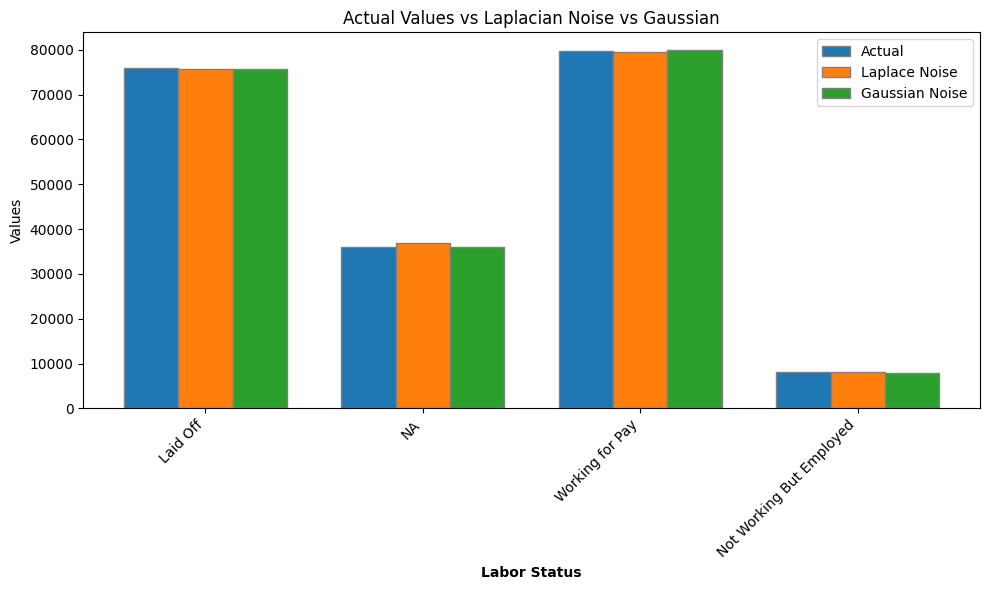

In [11]:
df = pl.DataFrame(all_values)
bar_width = 0.25
r1 = range(len(df["ILOSTAT"].to_list()))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, df["Actual"].to_list(), color='tab:blue', width=bar_width, edgecolor='grey', label='Actual')
plt.bar(r2, df["Laplace Noise"].to_list(), color='tab:orange', width=bar_width, edgecolor='grey', label='Laplace Noise')
plt.bar(r3, df["Gaussian Noise"].to_list(), color='tab:green', width=bar_width, edgecolor='grey', label='Gaussian Noise')

plt.xlabel('Labor Status', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(df["ILOSTAT"].to_list()))], df["ILOSTAT"].to_list(), rotation=45, ha='right')
plt.ylabel('Values')
plt.title('Actual Values vs Laplacian Noise vs Gaussian')

plt.legend()
plt.tight_layout()
plt.show()

Our differentially private outputs are quite accurate compared to the actual values. However, the outputs using Laplacian and Gaussian noise do not differ significantly from a visual perspective. This won't always be the case, and as you begin to apply differential privacy to more specialized applications, specifying the type of noise you want to add may increase utility.

## Conclusion

In this notebook, we accomplished the following objectives: 
- Understand the common differences between using Laplacian noise and Gaussian Noise. 
- Understand which applications may be better suited for Laplacian noise or Gaussian Noise. 
- Demonstrate how to specify the type of noise in the Context API.  